# Exploratory Data Analysis: Trip Duration

- id: a unique identifier for each trip
- vendor_id: a code indicating the provider associated with the trip record
- pickup_datetime: date and time when the meter was engaged
- dropoff_datetime: date and time when the meter was disengaged
- passenger_count: the number of passengers in the vehicle (driver entered value)
- pickup_longitude: the longitude where the meter was engaged
- pickup_latitude: the latitude where the meter was engaged
- dropoff_longitude: the longitude where the meter was disengaged
- dropoff_latitude: the latitude where the meter was disengaged
- store_and_fwd_flag: This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)
- trip_duration: duration of the trip in seconds

Obviously dropoff_datetime and trip_duration are only available for the train set.

In [1]:
%%time

# Import Standard Libraries
import os
import sys
import warnings
# warnings.filterwarnings("ignore")

# Import Data Handling Libraries
import pandas as pd
import numpy as np
np.random.seed(42)

# Import Date-Time Handling Libraries
from datetime import timedelta
import datetime as dt

# Import Geodetic Libraries
import pyproj
from pyproj import Geod

# Import Data Visualization Libraries
import matplotlib
matplotlib.rcParams["font.size"] = 12
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [12, 12]  # Set default figure size
import seaborn as sns

# Import Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA  # Principal Component Analysis
from sklearn.cluster import MiniBatchKMeans  # Clustering algorithm for large datasets
from scipy import stats

# Set random seed for reproducibility in scikit-learn
from sklearn.utils import check_random_state
rng = check_random_state(42)

# TBC
import gc
from tqdm import tqdm
import joblib

# Import Custom Modules
from data_loader import *  # Custom data loading functions

CPU times: user 3.54 s, sys: 6.81 s, total: 10.4 s
Wall time: 2.01 s


In [2]:
%%time

# Genrate directories for utils outcome genrated
os.makedirs("images", exist_ok=True)

CPU times: user 54 µs, sys: 0 ns, total: 54 µs
Wall time: 59.1 µs


In [3]:
%%time

# Configure color palettes
colors_b = sns.color_palette(palette="GnBu", n_colors=6)

CPU times: user 1.81 ms, sys: 0 ns, total: 1.81 ms
Wall time: 1.63 ms


In [4]:
%%time

# Load the dataset
data = load_data("data")
data.head()

Detected environment: sys
Loading data.csv from: /root/CEGE0042-STDM/data/data.csv
CPU times: user 2.55 s, sys: 470 ms, total: 3.02 s
Wall time: 3.01 s


,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [5]:
%%time

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB
CPU times: user 138 ms, sys: 0 ns, total: 138 ms
Wall time: 135 ms


In the given Kaggle competition, ground truth labels are only provided for the training dataset, while the test dataset lacks publicly available labels. As a result, for the STDM project, the training dataset is exlusively leveraged for model development, evaluation, and analysis. Without access to the test labels, we focus on techniques such as cross-validation and train-validation splits to assess model performance effectively.

## Validating Dataset Integrity & Quality

In [6]:
%%time

# Ensure `pickup_datetime` and `dropoff_datetime` are in datetime format
data["pickup_datetime"] = pd.to_datetime(data["pickup_datetime"])
data["dropoff_datetime"] = pd.to_datetime(data["dropoff_datetime"])

# Check if dropoff_datetime - pickup_datetime equals trip_duration (in seconds) for each record
assert all((data["dropoff_datetime"] - data["pickup_datetime"]).dt.total_seconds() == data["trip_duration"]), \
    "The difference between dropoff_datetime and pickup_datetime should equal the trip_duration for each record."

# Check if id is unique
assert data["id"].is_unique, "id column should contain unique values."

# Check if store_and_fwd_flag contains only 2 kinds of variables
assert set(data["store_and_fwd_flag"].unique()).issubset({"Y", "N"}), "store_and_fwd_flag should contain only `Y` and `N` values."

# Check there are no missing values
assert not data.isnull().values.any(), "Dataset contains missing values!"

# Print success message if all checks pass
print("All checks validating dataset integrity & quality passed successfully!")

All checks validating dataset integrity & quality passed successfully!
CPU times: user 1.16 s, sys: 21 ms, total: 1.18 s
Wall time: 1.18 s


## Overview Data Distribution

In [7]:
%%time

data["trip_duration [min]"] = data["trip_duration"] / 60.0
data["log_duration"] = np.log1p(data["trip_duration [min]"])

CPU times: user 8.7 ms, sys: 4.61 ms, total: 13.3 ms
Wall time: 10.6 ms


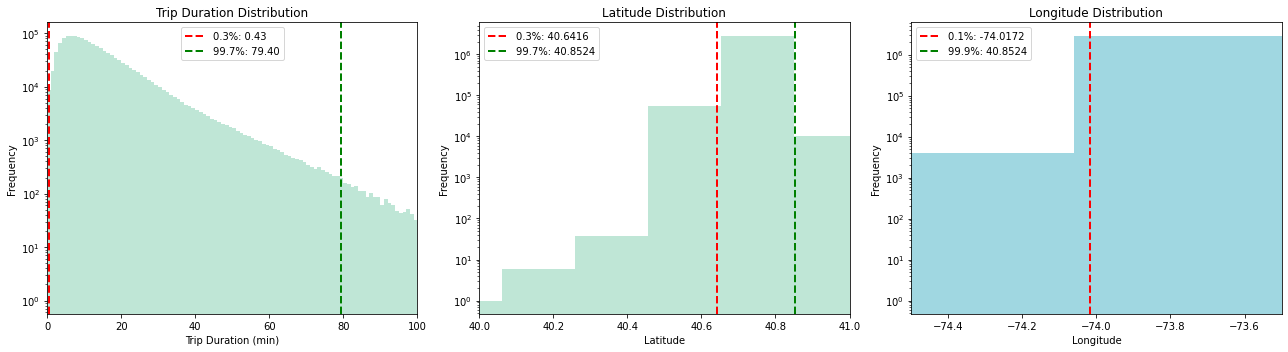

CPU times: user 3min 43s, sys: 3.05 s, total: 3min 46s
Wall time: 3min 44s


In [8]:
%%time

# Calculate value occurrences of longtitudes & latitudes
all_lat = np.array(list(data["pickup_latitude"]) + list(data["dropoff_latitude"]))
all_long = np.array(list(data["pickup_longitude"]) + list(data["dropoff_longitude"]))

# Calculate the percentile limits for latitude, longitude, and trip duration
long_limits = [np.percentile(all_long, 0.3), np.percentile(all_lat, 99.7)]
lat_limits = [np.percentile(all_lat, 0.3), np.percentile(all_lat, 99.7)]
dur_limits = [np.percentile(data["trip_duration [min]"], 0.3), np.percentile(data["trip_duration [min]"], 99.7)]

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot trip duration histogram
trip_min = int(data["trip_duration [min]"].min())
trip_max = int(data["trip_duration [min]"].max())

axes[0].hist(data["trip_duration [min]"], bins=np.arange(trip_min, trip_max + 1, 1), color=colors_b[2], alpha=0.6)
axes[0].axvline(dur_limits[0], color="red", linestyle="dashed", linewidth=2, label=f"0.3%: {dur_limits[0]:.2f}")
axes[0].axvline(dur_limits[1], color="green", linestyle="dashed", linewidth=2, label=f"99.7%: {dur_limits[1]:.2f}")
axes[0].set_title("Trip Duration Distribution")
axes[0].set_xlim([0, 100])
axes[0].set_xlabel("Trip Duration (min)")
axes[0].set_ylabel("Frequency")
axes[0].set_yscale("log")
axes[0].legend()

# Plot latitude histogram
axes[1].hist(all_lat, bins=100, color=colors_b[2], alpha=0.6)
axes[1].axvline(lat_limits[0], color="red", linestyle="dashed", linewidth=2, label=f"0.3%: {lat_limits[0]:.4f}")
axes[1].axvline(lat_limits[1], color="green", linestyle="dashed", linewidth=2, label=f"99.7%: {lat_limits[1]:.4f}")
axes[1].set_title("Latitude Distribution")
axes[1].set_xlim([40, 41])
axes[1].set_xlabel("Latitude")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale("log")
axes[1].legend()

# Plot longitude histogram
axes[2].hist(all_long, bins=100, color=colors_b[3], alpha=0.6)
axes[2].axvline(long_limits[0], color="red", linestyle="dashed", linewidth=2, label=f"0.1%: {long_limits[0]:.4f}")
axes[2].axvline(long_limits[1], color="green", linestyle="dashed", linewidth=2, label=f"99.9%: {long_limits[1]:.4f}")
axes[2].set_title("Longitude Distribution")
axes[2].set_xlim([-74.5, -73.5])
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Frequency")
axes[2].set_yscale("log")
axes[2].legend()

# Adjust layout and save plot
plt.tight_layout()
plt.savefig("images/raw_trip_data_log_distribution.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

## Remove Extreme Outliers (0.3% / 99.7% Percentile & 0.1% / 99.9% Percentile)

In [9]:
%%time

# Store the original number of records
original_count = len(data)

# Remove rows where latitude, longitude, or trip duration fall outside the limits
data = data[(data["pickup_latitude"] >= lat_limits[0]) & (data["pickup_latitude"] <= lat_limits[1])]
data = data[(data["dropoff_latitude"] >= lat_limits[0]) & (data["dropoff_latitude"] <= lat_limits[1])]
data = data[(data["pickup_longitude"] >= long_limits[0]) & (data["pickup_longitude"] <= long_limits[1])]
data = data[(data["dropoff_longitude"] >= long_limits[0]) & (data["dropoff_longitude"] <= long_limits[1])]
data = data[(data["trip_duration [min]"] >= dur_limits[0]) & (data["trip_duration [min]"] <= dur_limits[1])]

# Reset the index after filtering
data = data.reset_index(drop=True)

# Calculate the number of dropped records
dropped_count = original_count - len(data)
print(f"Total records dropped: {dropped_count}")

Total records dropped: 30472
CPU times: user 532 ms, sys: 280 ms, total: 812 ms
Wall time: 809 ms


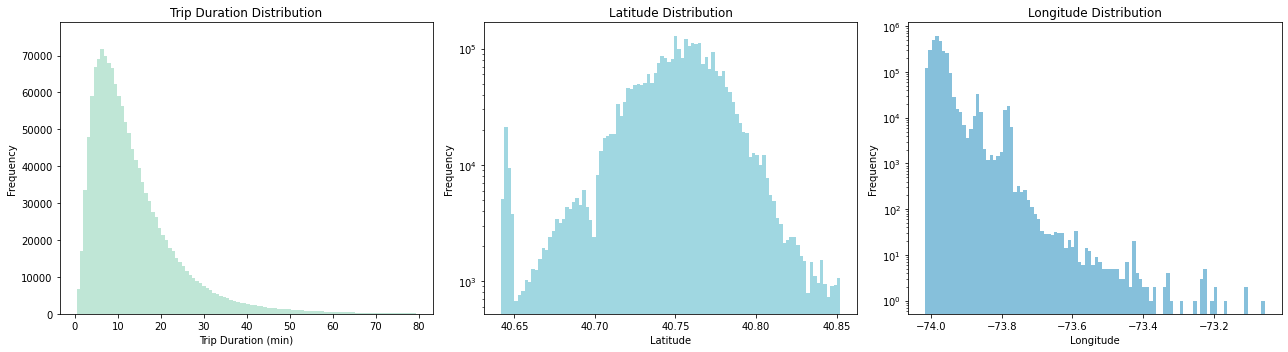

CPU times: user 3.32 s, sys: 784 ms, total: 4.1 s
Wall time: 3.23 s


In [10]:
%%time

# Recalculate value occurrences of longtitudes & latitudes
all_lat = np.array(list(data["pickup_latitude"]) + list(data["dropoff_latitude"]))
all_long = np.array(list(data["pickup_longitude"]) + list(data["dropoff_longitude"]))

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# Plot trip duration histogram
n, bins, patches = axes[0].hist(data["trip_duration [min]"], bins=100, color=colors_b[2], alpha=0.6)
axes[0].set_title("Trip Duration Distribution")
axes[0].set_xlabel("Trip Duration (min)")
axes[0].set_ylabel("Frequency")
axes[0].set_ylim(0, max(n) * 1.1)  # Set y-axis range (10% extra for padding)

# Plot latitude histogram
n, bins, patches = axes[1].hist(all_lat, bins=100, color=colors_b[3], alpha=0.6)
axes[1].set_title("Latitude Distribution")
axes[1].set_xlabel("Latitude")
axes[1].set_ylabel("Frequency")
axes[1].set_yscale("log")

# Plot longitude histogram
n, bins, patches = axes[2].hist(all_long, bins=100, color=colors_b[4], alpha=0.6)
axes[2].set_title("Longitude Distribution")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Frequency")
axes[2].set_yscale("log")

# Adjust layout and save plot
plt.tight_layout()
plt.savefig("images/removed_trip_data_log_distribution.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

## Skimming Dataset with Visualizations: Spatial Patterns

### Lower & Upper Limits of Longitude & Latitude

In [11]:
%%time

# Combine pickup and dropoff coordinates for longitude and latitude
combined_longitude = np.concatenate([data["pickup_longitude"].values, data["dropoff_longitude"].values])
combined_latitude = np.concatenate([data["pickup_latitude"].values, data["dropoff_latitude"].values])

# Find the min and max values for longitude and latitude
min_longitude = combined_longitude.min()
max_longitude = combined_longitude.max()

min_latitude = combined_latitude.min()
max_latitude = combined_latitude.max()

# Print the results
print("Longitude: Min = {}, Max = {}".format(min_longitude, max_longitude))
print("Latitude: Min = {}, Max = {}".format(min_latitude, max_latitude))

Longitude: Min = -74.0172348022461, Max = -73.05597686767578
Latitude: Min = 40.64159393310546, Max = 40.85240173339844
CPU times: user 16.7 ms, sys: 188 µs, total: 16.9 ms
Wall time: 13.8 ms


### Trip Duration vs. Euclidean Distance between Pickup & Dropoff

In [12]:
%%time

# Define WGS84 ellipsoid
geod = Geod(ellps="WGS84")

# Compute great-circle distance in kilometers
data["euclidean_distance"] = data.apply(
    lambda row: geod.inv(row["pickup_longitude"], row["pickup_latitude"],
                         row["dropoff_longitude"], row["dropoff_latitude"])[2] / 1000, axis=1
)

CPU times: user 23.4 s, sys: 524 ms, total: 23.9 s
Wall time: 23.9 s


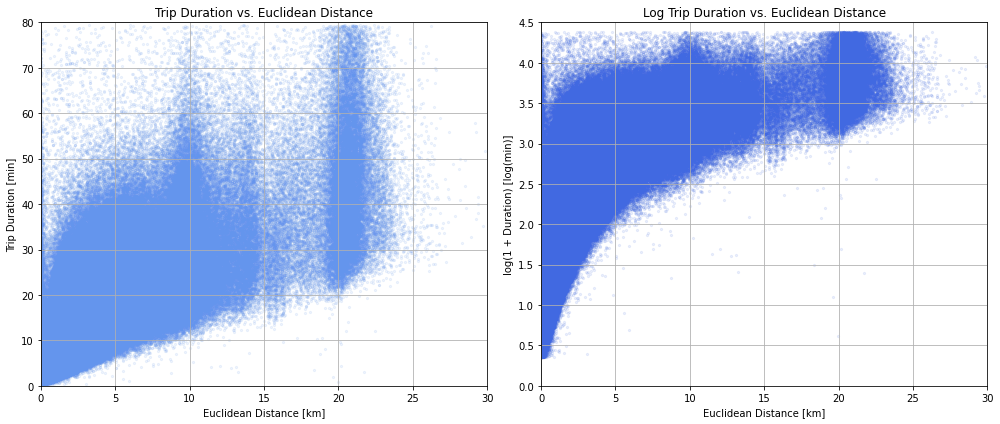

CPU times: user 14.5 s, sys: 525 ms, total: 15.1 s
Wall time: 14.4 s


In [13]:
%%time

# Create subplots
fig, axArray = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Scatter plot of duration vs. aerial distance
sc1 = axArray[0].scatter(data["euclidean_distance"], data["trip_duration [min]"], 
                         c="cornflowerblue", s=5, alpha=0.1)
axArray[0].set_xlabel("Euclidean Distance [km]")
axArray[0].set_ylabel("Trip Duration [min]")
axArray[0].set_xlim(0, 30)
axArray[0].set_ylim(0, 80)
axArray[0].set_title("Trip Duration vs. Euclidean Distance")
axArray[0].grid(True)

# Scatter plot of log duration vs. aerial distance
sc2 = axArray[1].scatter(data["euclidean_distance"], data["log_duration"], 
                         c="royalblue", s=5, alpha=0.1)
axArray[1].set_xlabel("Euclidean Distance [km]")
axArray[1].set_ylabel("log(1 + Duration) [log(min)]")
axArray[1].set_xlim(0, 30)
axArray[1].set_ylim(0, 4.5)
axArray[1].set_title("Log Trip Duration vs. Euclidean Distance")
axArray[1].grid(True)

# Adjust layout
plt.tight_layout()

# Save the figure
plt.savefig(f"images/trip_duration_vs_euclidan_distance.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

### Pick-up & Drop-off Location Density

Pickups dropped: 169, Dropoffs dropped: 1842


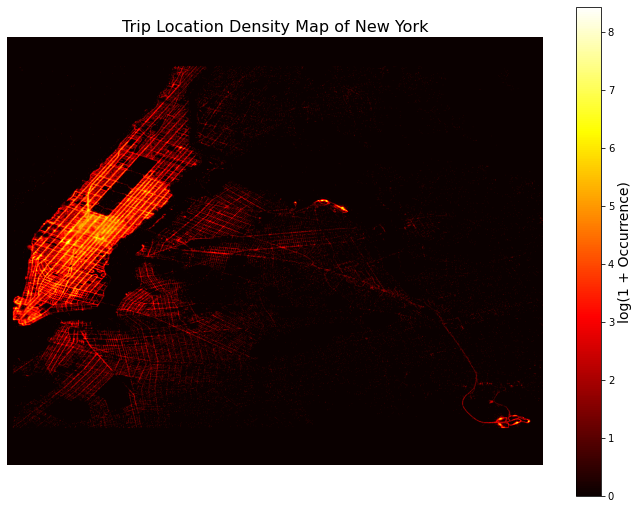

CPU times: user 3.55 s, sys: 457 ms, total: 4.01 s
Wall time: 3.47 s


In [14]:
%%time

# Define valid geographic bounds for New York
lat_min, lat_max = 40.62, 40.87         # 0.25
lon_min, lon_max = -74.02, -73.77       # 0.25

# Filter data within the specified range
valid_pickup = (data["pickup_latitude"].between(lat_min, lat_max)) & (data["pickup_longitude"].between(lon_min, lon_max))
valid_dropoff = (data["dropoff_latitude"].between(lat_min, lat_max)) & (data["dropoff_longitude"].between(lon_min, lon_max))

# Count dropped data points
dropped_pickups = len(data) - valid_pickup.sum()
dropped_dropoffs = len(data) - valid_dropoff.sum()
print(f"Pickups dropped: {dropped_pickups}, Dropoffs dropped: {dropped_dropoffs}")

# Keep only valid data
pickup_lons = data.loc[valid_pickup, "pickup_longitude"]
pickup_lats = data.loc[valid_pickup, "pickup_latitude"]
dropoff_lons = data.loc[valid_dropoff, "dropoff_longitude"]
dropoff_lats = data.loc[valid_dropoff, "dropoff_latitude"]

# Define image size
img_sz = (800, 1000)

# Normalize coordinates to fit image dimensions directly in WGS84
pickup_x_inds = ((img_sz[1] * (pickup_lons - lon_min) / (lon_max - lon_min))).astype(int)
pickup_y_inds = (img_sz[0] - (img_sz[0] * (pickup_lats - lat_min) / (lat_max - lat_min))).astype(int)

dropoff_x_inds = ((img_sz[1] * (dropoff_lons - lon_min) / (lon_max - lon_min))).astype(int)
dropoff_y_inds = (img_sz[0] - (img_sz[0] * (dropoff_lats - lat_min) / (lat_max - lat_min))).astype(int)

# Initialize density image
location_density_image = np.zeros(img_sz)

# Update the density map with valid pickup and dropoff locations
for x, y in zip(pickup_x_inds, pickup_y_inds):
    if 0 <= x < img_sz[1] and 0 <= y < img_sz[0]:
        location_density_image[y, x] += 1

for x, y in zip(dropoff_x_inds, dropoff_y_inds):
    if 0 <= x < img_sz[1] and 0 <= y < img_sz[0]:
        location_density_image[y, x] += 1

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 15))
im = ax.imshow(np.log(location_density_image + 1), cmap="hot")  # Apply log transform for better visibility
ax.set_axis_off()

# Add a title
ax.set_title("Trip Location Density Map of New York", fontsize=16)

# Add a colorbar with label indicating the density
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label("log(1 + Occurrence)", fontsize=14)

# Save the plot to a PNG file in the "images" directory
plt.savefig("images/heatmap_density.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

The figure highlights the popularity of pickup and drop-off locations, with lighter patterns indicating areas of high occurrence. In New York, the Manhattan region and two major airports (John F. Kennedy International Airport (JFK) and LaGuardia Airport (LGA)) are particularly notable for their high levels of activity. Within Manhattan, the absence of taxis around Central Park is also evident, as the area is marked in black due to restrictions on taxi access. Additionally, lakes, rivers, and green spaces are also represented in black on the figure, signifying that these areas are not utilized for taxi services.

Pickups dropped: 60869, Dropoffs dropped: 79491


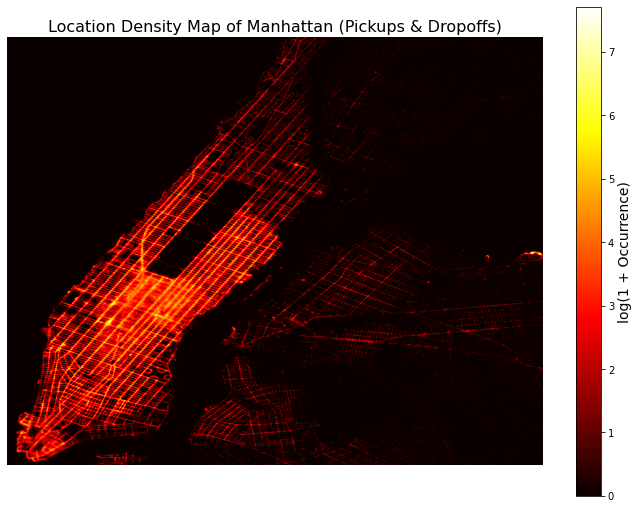

CPU times: user 3.52 s, sys: 528 ms, total: 4.05 s
Wall time: 3.51 s


In [15]:
%%time

# Define valid geographic bounds for Manhattan
lat_min_, lat_max_ = 40.70, 40.85       # 0.15
lon_min_, lon_max_ = -74.02, -73.87     # 0.15

# Filter data within the specified range
valid_pickup = (data["pickup_latitude"].between(lat_min_, lat_max_)) & (data["pickup_longitude"].between(lon_min_, lon_max_))
valid_dropoff = (data["dropoff_latitude"].between(lat_min_, lat_max_)) & (data["dropoff_longitude"].between(lon_min_, lon_max_))

# Count dropped data points
dropped_pickups = len(data) - valid_pickup.sum()
dropped_dropoffs = len(data) - valid_dropoff.sum()
print(f"Pickups dropped: {dropped_pickups}, Dropoffs dropped: {dropped_dropoffs}")

# Keep only valid data
pickup_lons = data.loc[valid_pickup, "pickup_longitude"]
pickup_lats = data.loc[valid_pickup, "pickup_latitude"]
dropoff_lons = data.loc[valid_dropoff, "dropoff_longitude"]
dropoff_lats = data.loc[valid_dropoff, "dropoff_latitude"]


# Normalize coordinates to fit image dimensions directly in WGS84
pickup_x_inds = ((img_sz[1] * (pickup_lons - lon_min_) / (lon_max_ - lon_min_))).astype(int)
pickup_y_inds = (img_sz[0] - (img_sz[0] * (pickup_lats - lat_min_) / (lat_max_ - lat_min_))).astype(int)

dropoff_x_inds = ((img_sz[1] * (dropoff_lons - lon_min_) / (lon_max_ - lon_min_))).astype(int)
dropoff_y_inds = (img_sz[0] - (img_sz[0] * (dropoff_lats - lat_min_) / (lat_max_ - lat_min_))).astype(int)

# Initialize density image
location_density_image_ = np.zeros(img_sz)

# Update the density map with valid pickup and dropoff locations
for x, y in zip(pickup_x_inds, pickup_y_inds):
    if 0 <= x < img_sz[1] and 0 <= y < img_sz[0]:
        location_density_image_[y, x] += 1

for x, y in zip(dropoff_x_inds, dropoff_y_inds):
    if 0 <= x < img_sz[1] and 0 <= y < img_sz[0]:
        location_density_image_[y, x] += 1

# Plot the heatmap
fig, ax = plt.subplots(figsize=(12, 15))
im = ax.imshow(np.log(location_density_image_ + 1), cmap="hot")  # Apply log transform for better visibility
ax.set_axis_off()

# Add a title
ax.set_title("Location Density Map of Manhattan (Pickups & Dropoffs)", fontsize=16)

# Add a colorbar with label indicating the density
cbar = fig.colorbar(im, ax=ax, shrink=0.6)
cbar.set_label("log(1 + Occurrence)", fontsize=14)

# Save the plot to a PNG file in the "images" directory
plt.savefig("images/heatmap_density_manhattan.png", bbox_inches="tight", pad_inches=0.1, dpi=300)

# Show the plot
plt.show()

### Clusters of Stereotypical Template Trips

In [16]:
%%time

# Extract relevant columns from the `data` dataframe
trip_attributes = np.array(data.loc[:, ["pickup_latitude", "pickup_longitude", "dropoff_latitude", "dropoff_longitude", "trip_duration [min]"]])

# Calculate the mean and standard deviation for z-score normalization
mean_trip_attr = trip_attributes.mean(axis=0)
std_trip_attr = trip_attributes.std(axis=0)

# Normalize the trip_attributes using z-score
trip_attributes = stats.zscore(trip_attributes, axis=0)

CPU times: user 98 ms, sys: 32.1 ms, total: 130 ms
Wall time: 128 ms


In [17]:
%%time

# Number of clusters
num_clusters = 84

# Apply MiniBatchKMeans clustering
trip_kmeans_model = MiniBatchKMeans(n_clusters=num_clusters, batch_size=131072, n_init=128, random_state=42)
cluster_inds = trip_kmeans_model.fit_predict(trip_attributes)

# Count the frequency of each cluster
cluster_total_counts, _ = np.histogram(cluster_inds, bins=num_clusters)

# Sort clusters by frequency
sorted_cluster_inds = np.flipud(np.argsort(cluster_total_counts))

CPU times: user 20min 26s, sys: 56min 56s, total: 1h 17min 22s
Wall time: 2min 29s


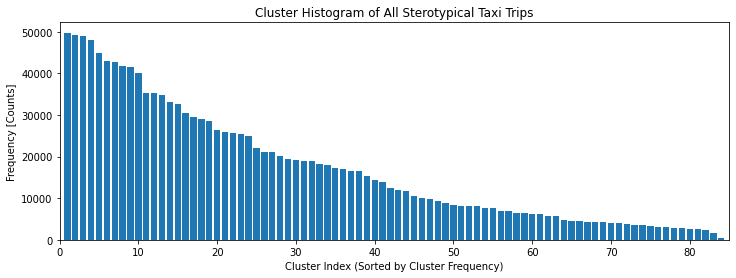

CPU times: user 618 ms, sys: 413 ms, total: 1.03 s
Wall time: 512 ms


In [18]:
%%time

# Plot histogram of clusters
plt.figure(figsize=(12, 4))
plt.title("Cluster Histogram of All Sterotypical Taxi Trips")
plt.bar(range(1, num_clusters + 1), cluster_total_counts[sorted_cluster_inds])
plt.ylabel("Frequency [Counts]")
plt.xlabel("Cluster Index (Sorted by Cluster Frequency)")
plt.xlim(0, num_clusters + 1)

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/cluster_histogram.png", dpi=300, bbox_inches="tight")

# Show the plot
plt.show()

In [19]:
%%time

# Function to convert latitude/longitude to image coordinates
def convert_to_image_coords(lat, lon, lat_range, lon_range, image_size):
    lat_inds = image_size[0] - (image_size[0] * (lat - lat_range[0]) / (lat_range[1] - lat_range[0])).astype(int)
    lon_inds = (image_size[1] * (lon - lon_range[0]) / (lon_range[1] - lon_range[0])).astype(int)
    return lat_inds, lon_inds

CPU times: user 4 µs, sys: 9 µs, total: 13 µs
Wall time: 7.63 µs


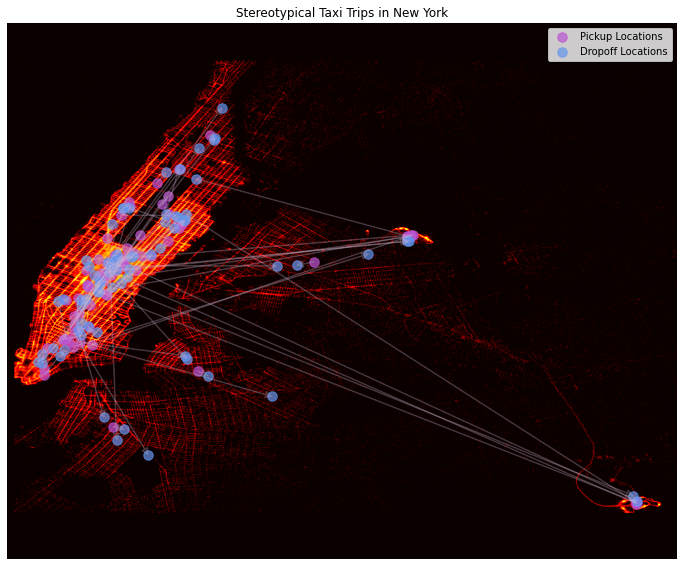

CPU times: user 2.19 s, sys: 618 ms, total: 2.81 s
Wall time: 2.27 s


In [20]:
%%time

# Define valid geographic bounds for Manhattan
lat_range = (lat_min, lat_max)
lon_range = (lon_min, lon_max)

# Get cluster centers (template trips)
top_clusters = np.argsort(cluster_total_counts)[-72:]
template_trips = trip_kmeans_model.cluster_centers_ * std_trip_attr + mean_trip_attr

# Extract source and destination coordinates
src_coords = template_trips[top_clusters, :2]  # Pickup latitude, longitude
dst_coords = template_trips[top_clusters, 2:4]  # Dropoff latitude, longitude

# Convert to image coordinates
src_im_coords = convert_to_image_coords(src_coords[:, 0], src_coords[:, 1], lat_range, lon_range, img_sz)
dst_im_coords = convert_to_image_coords(dst_coords[:, 0], dst_coords[:, 1], lat_range, lon_range, img_sz)

# Plot template trips
plt.figure(figsize=(12, 12))
plt.imshow(np.log(location_density_image + 1), cmap="hot")
plt.scatter(src_im_coords[1], src_im_coords[0], c="mediumorchid", s=90, alpha=0.7, label="Pickup Locations")
plt.scatter(dst_im_coords[1], dst_im_coords[0], c="cornflowerblue", s=90, alpha=0.7, label="Dropoff Locations")

# Draw arrows for trips
for i in range(len(src_im_coords[0])):
    plt.arrow(src_im_coords[1][i], src_im_coords[0][i],
              dst_im_coords[1][i] - src_im_coords[1][i],
              dst_im_coords[0][i] - src_im_coords[0][i],
              edgecolor="thistle", facecolor="thistle", width=0.8, alpha=0.2,
              head_width=10.0, head_length=10.0, length_includes_head=True)

# Add labels and legend
plt.title("Stereotypical Taxi Trips in New York")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.grid(False)
plt.axis("off")

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/top_common_stereotypical_trips_new_york.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

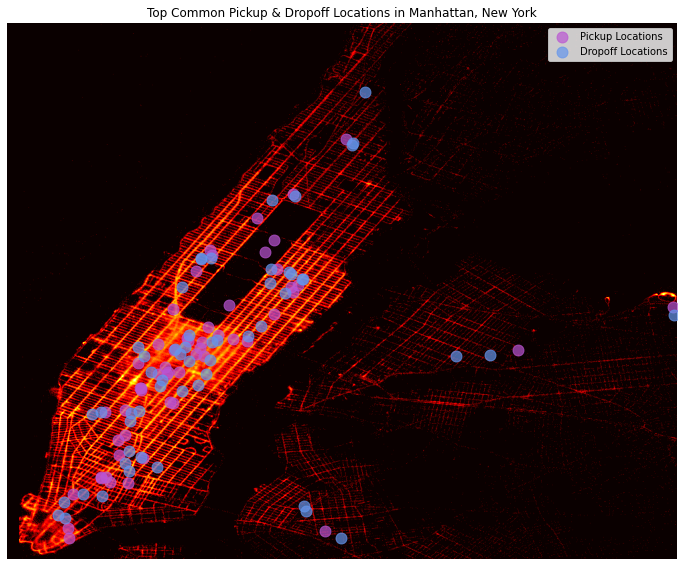

CPU times: user 2.15 s, sys: 608 ms, total: 2.75 s
Wall time: 2.21 s


In [21]:
%%time

# Define valid geographic bounds for Manhattan
lat_range_ = (lat_min_, lat_max_)
lon_range_ = (lon_min_, lon_max_)

# Get cluster centers (template trips)
top_clusters = np.argsort(cluster_total_counts)[-64:]  # Get indices of top 50 clusters
template_trips = trip_kmeans_model.cluster_centers_ * std_trip_attr + mean_trip_attr

# Extract source and destination coordinates
src_coords = template_trips[top_clusters, :2]  # Pickup latitude, longitude
dst_coords = template_trips[top_clusters, 2:4]  # Dropoff latitude, longitude

# Filter trips within Manhattan bounds
valid_src_mask = (lat_min_ <= src_coords[:, 0]) & (src_coords[:, 0] <= lat_max_) & \
                 (lon_min_ <= src_coords[:, 1]) & (src_coords[:, 1] <= lon_max_)
valid_dst_mask = (lat_min_ <= dst_coords[:, 0]) & (dst_coords[:, 0] <= lat_max_) & \
                 (lon_min_ <= dst_coords[:, 1]) & (dst_coords[:, 1] <= lon_max_)

# Keep only trips where both pickup and dropoff are within Manhattan
valid_trips_mask = valid_src_mask & valid_dst_mask
filtered_src_coords = src_coords[valid_trips_mask]
filtered_dst_coords = dst_coords[valid_trips_mask]

# Convert to image coordinates
src_im_coords = convert_to_image_coords(filtered_src_coords[:, 0], filtered_src_coords[:, 1], lat_range_, lon_range_, img_sz)
dst_im_coords = convert_to_image_coords(filtered_dst_coords[:, 0], filtered_dst_coords[:, 1], lat_range_, lon_range_, img_sz)

# Plot template trips
plt.figure(figsize=(12, 12))
plt.imshow(np.log(location_density_image_ + 1), cmap="hot")

# Plot pickup and dropoff locations
plt.scatter(src_im_coords[1], src_im_coords[0], c="mediumorchid", s=120, alpha=0.7, label="Pickup Locations")
plt.scatter(dst_im_coords[1], dst_im_coords[0], c="cornflowerblue", s=120, alpha=0.7, label="Dropoff Locations")

# Add labels and legend
plt.title("Top Common Pickup & Dropoff Locations in Manhattan, New York")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.legend()
plt.axis("off")  # Remove axis

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/top_common_stereotypical_trips_manhattan.png", dpi=300, bbox_inches="tight")

# Show plot
plt.show()

The data reveals an uneven distribution of pickup and dropoff locations, with the periphery of Manhattan predominantly serving as the dropoff area. Pickups are most commonly observed in Manhattan, airports, and select regions of Brooklyn and Queens. This suggests that cross-borough commuting is common between Manhattan, Brooklyn, and Queens.

## Skimming Dataset with Visualizations: Temporal Patterns

In [22]:
%%time

# Generate detailed date-time fields for pickups
pickup_times = pd.to_datetime(data["pickup_datetime"])

data["pickup_hour_of_day"] = (pickup_times.dt.hour * 60.0 + pickup_times.dt.minute) / 60.0
data["dropoff_hour_of_day"] = data["pickup_hour_of_day"] + data["trip_duration [min]"] / 60.0

data["day_of_week"] = pickup_times.dt.weekday
data["hour_of_week"] = data["day_of_week"] * 24.0 + data["pickup_hour_of_day"]

data["month_of_year"] = pickup_times.dt.month
data["day_of_year"] = pickup_times.dt.dayofyear
data["week_of_year"] = pickup_times.dt.isocalendar().week
data["hour_of_year"] = data["day_of_year"] * 24.0 + data["pickup_hour_of_day"]

CPU times: user 421 ms, sys: 5.13 ms, total: 426 ms
Wall time: 424 ms


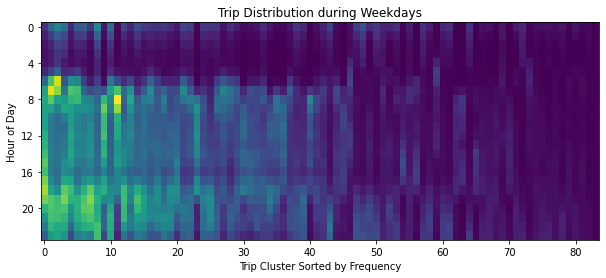

CPU times: user 644 ms, sys: 377 ms, total: 1.02 s
Wall time: 595 ms


In [23]:
%%time

# Calculate trip distribution for different hours of the weekday
hours_of_day = np.sort(data["pickup_hour_of_day"].astype(int).unique())
cluster_distribution_hour_of_day_weekday = np.zeros((len(hours_of_day), num_clusters))

# Calculate trip distribution for each hour of the day on weekdays
for k, hour in enumerate(hours_of_day):
    selected_inds = (data["pickup_hour_of_day"].astype(int) == hour) & (data["day_of_week"] <= 4)  # Weekdays (Mon-Fri)
    curr_distribution, _ = np.histogram(cluster_inds[selected_inds], bins=num_clusters)
    cluster_distribution_hour_of_day_weekday[k, :] = curr_distribution

# Calculate the frequency of each cluster
cluster_frequencies = np.sum(cluster_distribution_hour_of_day_weekday, axis=0)

# Get sorted indices based on frequency (highest frequency first)
sorted_cluster_indices = np.argsort(cluster_frequencies)[::-1]

# Reorder the cluster distribution matrix based on sorted cluster indices
cluster_distribution_hour_of_day_weekday_sorted = cluster_distribution_hour_of_day_weekday[:, sorted_cluster_indices]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.set_title("Trip Distribution during Weekdays", fontsize=12)
ax.imshow(cluster_distribution_hour_of_day_weekday_sorted, aspect="auto", cmap="viridis")
ax.grid(False)
ax.set_xlabel("Trip Cluster Sorted by Frequency")
ax.set_ylabel("Hour of Day")
ax.set_yticks(np.arange(0, 24, 4))

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/trip_distribution_weekdays_by_hour_sorted.png", dpi=300, bbox_inches="tight")

plt.show()

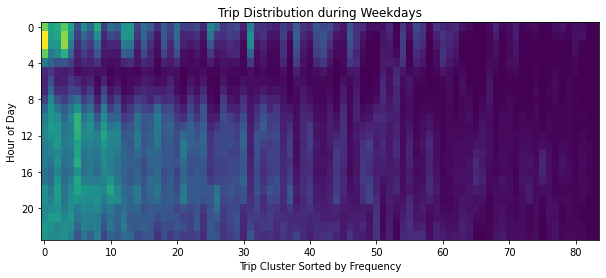

CPU times: user 680 ms, sys: 430 ms, total: 1.11 s
Wall time: 584 ms


In [24]:
%%time

# Calculate trip distribution for different hours of the weekday
hours_of_day = np.sort(data["pickup_hour_of_day"].astype(int).unique())
cluster_distribution_hour_of_day_weekday = np.zeros((len(hours_of_day), num_clusters))

# Calculate trip distribution for each hour of the day on weekdays
for k, hour in enumerate(hours_of_day):
    selected_inds = (data["pickup_hour_of_day"].astype(int) == hour) & (data["day_of_week"] > 4)  # Weekends (Sat-Sun)
    curr_distribution, _ = np.histogram(cluster_inds[selected_inds], bins=num_clusters)
    cluster_distribution_hour_of_day_weekday[k, :] = curr_distribution

# Calculate the frequency of each cluster
cluster_frequencies = np.sum(cluster_distribution_hour_of_day_weekday, axis=0)

# Get sorted indices based on frequency (highest frequency first)
sorted_cluster_indices = np.argsort(cluster_frequencies)[::-1]

# Reorder the cluster distribution matrix based on sorted cluster indices
cluster_distribution_hour_of_day_weekday_sorted = cluster_distribution_hour_of_day_weekday[:, sorted_cluster_indices]

# Plotting
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
ax.set_title("Trip Distribution during Weekdays", fontsize=12)
ax.imshow(cluster_distribution_hour_of_day_weekday_sorted, aspect="auto", cmap="viridis")
ax.grid(False)
ax.set_xlabel("Trip Cluster Sorted by Frequency")
ax.set_ylabel("Hour of Day")
ax.set_yticks(np.arange(0, 24, 4))

# Save the plot as a PNG file with 300 dpi
plt.savefig("images/trip_distribution_weekends_by_hour_sorted.png", dpi=300, bbox_inches="tight")

plt.show()

---